In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. We'll try as much as possible to build from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can switch over to PyTorch's version. This is similar to how things are done in the course. However, this is not just a "copy / paste" of the course: on many occasions I take a different route, and most of the code is my own. That is not to say that all of this is meant to be extremely innovative, instead I had the following goals:

- Deeply understand the training of neural networks with a focus on PyTorch
- Try to create an even better narrative then what's presented in FastAI 🙉🤷‍♂️🙈
- Get hands-on experience with creating a library with [`nb_dev`](https://nbdev.fast.ai/)

`nb_dev` is another great project from the fastai community, which allows python libraries to be written in jupyter notebooks. This may sound a bit weird since the mainstream paradigm is to only do experimental work in notebooks. It has the advantage though that we can create the source code for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea and other nice features of `nb_dev`, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with where we left off in the previous [post](https://lucasvw.github.io/posts/10_nntrain_learner/):

## End of last post:

We finished the last post with exporting the `learner` module into the `nntrain` library. In this post, we are going to use both the Dataloaders as well as the Learner object. To start we are finally changing our naive MLP model to something that fits better to image data: a convolutional neural network. Accordingly, we need to load our data in a different way: we should keep the geometric structure of the image and not flatten the x and y coordinate out into a long vector, so let's start with that:

In [ ]:
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn
from nntrain.learner import *

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

bs = 1024

collate = partial(hf_ds_collate_fn, flatten=False)

dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs, collate_fn=collate)

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
xb = next(iter(dls.train))[0]
xb.shape

torch.Size([1024, 1, 28, 28])

Next, let's create a simple CNN consisting of a couple of convolutions with ReLU activations in between:

In [ ]:
def conv_block(in_c, out_c, kernel_size=3, act=True):
    conv = torch.nn.Conv2d(in_c, out_c, kernel_size, stride=2, padding=kernel_size//2)
    if act: return nn.Sequential(conv, torch.nn.ReLU())
    else: return conv

In [ ]:
def get_model():
    return nn.Sequential(
        # input shape : 28x28
        # first conv: from kernel_size=3, we have 3x3=9 image pixels to 4 outputs
        # so +- 2x compression
        conv_block(1 ,4),               # output shape: 14x14
        conv_block(4 ,8),               # output shape: 7x7
        conv_block(8 ,16),              # output shape: 4x4
        conv_block(16,32),              # output shape: 2x2
        conv_block(32,10, act=False),   # output shape: 1x1
        nn.Flatten(),                   # flatten to 10 outputs
    )
get_model()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

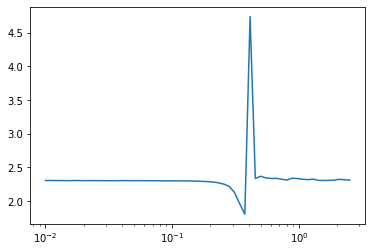

In [ ]:
progress_s = ProgressS(True)
metrics_s = MetricsS(accuracy=tem.MulticlassAccuracy())
device_s = DeviceS(device)
lrfind_s = LRFindS(mult=1.1)

l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics_s, device_s, progress_s])

# Let's see if we can find a good learning rate:
l.fit(1, lr=1e-2, subs=[lrfind_s])

lrfind_s.plot()

epoch,mode,loss,accuracy
0,train,2.281,0.180
0,eval,1.945,0.404
1,train,1.225,0.592
1,eval,0.661,0.755
2,train,0.557,0.795
2,eval,0.532,0.804
3,train,0.475,0.827
3,eval,0.474,0.830
4,train,0.431,0.843
4,eval,0.464,0.833


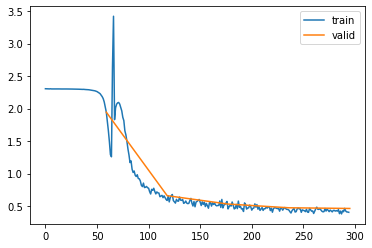

In [ ]:
l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics_s, device_s, progress_s])

l.fit(5, lr=0.1)

## Initialization

We see that at initialization of our network, our loss is between 2 and 2.5. In fact we can create a small Subscriber that cancels right after the first batch and check what the loss is:

In [ ]:
class OneBatchS(Subscriber):
    def after_backward(self, learn): raise CancelFitException

one_batch = OneBatchS()

l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [one_batch])
l.fit(5)
print(f'loss after first batch: {l.loss.item():.3f}')

loss after first batch: 2.304


And, we can ask ourselves whether this is a "good" or "bad" loss. To answer that question, we can compute the loss we would expect from our model based on random guessing. The use-case for our data is to select the right category for an image among a list of 10 categories. We would expect that before training the model has no idea, so it has to make a random guess, which would mean it should be correct for 10% of the images. Let's compute the negative loss likelihood of that scenario:

In [ ]:
p = 0.1
nll = - torch.tensor(0.1).log()
print(f'Negative Log Likelihood of {p:.0%} probability: {nll:.3f}')

Negative Log Likelihood of 10% probability: 2.303


That is in fact pretty close to the loss we are seeing. This means that indeed the model is initially making predictions that are very close to a uniform distribution (i.e. 10% probability to any of the classes), we can also look at actual predictions from the first batch:

In [ ]:
logits = l.preds               # our model outputs logits
probs = l.preds.softmax(dim=1) # turn into probabilities through a softmax
print(f'probabilities for the first 5 images:')
for p in probs[:5].data: print(p)

probabilities for the first 5 images:
tensor([0.1044, 0.0982, 0.1012, 0.1068, 0.1044, 0.0938, 0.0956, 0.0960, 0.0958,
        0.1037])
tensor([0.1045, 0.0984, 0.1010, 0.1067, 0.1044, 0.0938, 0.0957, 0.0962, 0.0957,
        0.1036])
tensor([0.1045, 0.0985, 0.1011, 0.1069, 0.1042, 0.0938, 0.0956, 0.0961, 0.0956,
        0.1038])
tensor([0.1045, 0.0983, 0.1011, 0.1068, 0.1044, 0.0938, 0.0957, 0.0960, 0.0958,
        0.1037])
tensor([0.1045, 0.0983, 0.1012, 0.1068, 0.1042, 0.0938, 0.0957, 0.0961, 0.0957,
        0.1037])


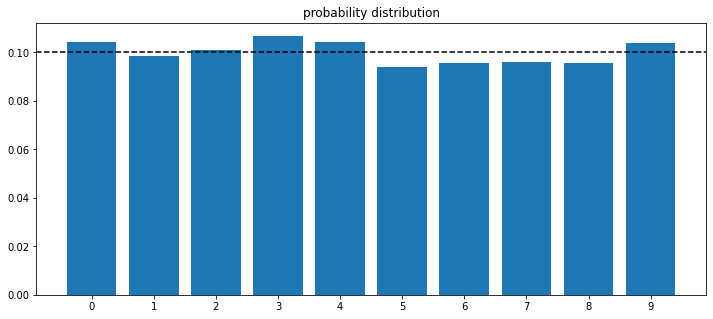

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,5))

axs.bar(x=range(0,10), height=probs.mean(dim=0).detach().cpu());
axs.set_title('probability distribution');
axs.axhline(0.1, c='black', ls='--');
axs.set_xticks(range(0,10));

So indeed everything is looking pretty good, the probability distribution looks fairly uniform. The reason that the initial state of the network is pretty good has to do with the way the network is initialized. In fact, the linear layers are initialized with Kaiming initialization, as we can see from the documentation. This scales the standard deviation to a level so that unit gaussian inputs that are going through the linear layer are still random unit gaussian afterward.

To understand what that's all about, let's have a look at what happens when we multiply matrices together as is done in linear layers. Let's start with data that is unit gaussian (a mean of 0 and a standard deviation of 1). In the figure below we see what happens when we multiply the inputs 4 times with a certain weight matrix (simulating a 4 layer deep neural network)

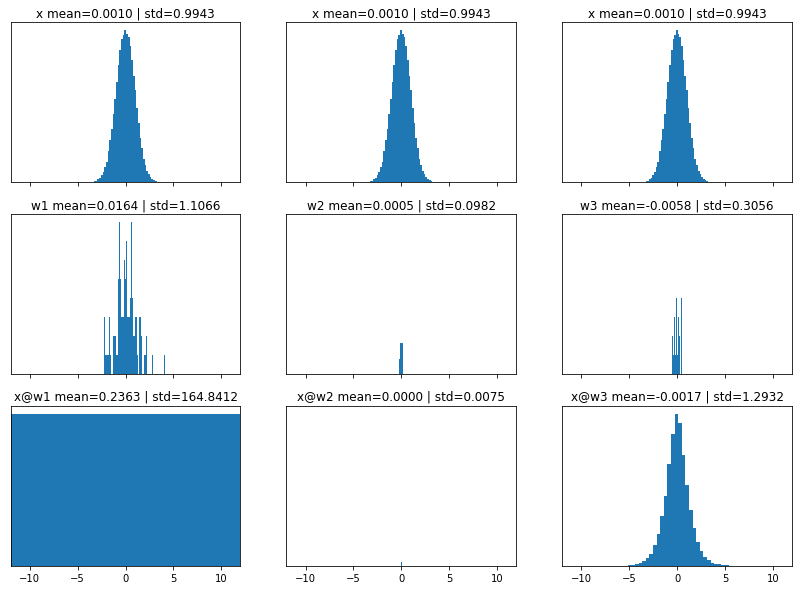

In [ ]:
x = torch.randn(10000, 10)       # the input data of shape [10000,10] | Unit Gaussian
w1 = torch.randn(10, 10)         # the weight matrix of a linear layer of shape [10,200] | Unit Gaussian
w2 = torch.randn(10, 10) * 0.1   # the weight matrix of a linear layer of shape [10,200] | Gaussian with standard deviation of 0.1
w3 = torch.nn.init.xavier_uniform_(torch.randn(10, 10)) # xavier init

def plot(c, w):
    out = x@w
    for i in range(3):
        out = out@w
    axs[0,c].hist(x.view(-1).tolist(), 50);
    axs[0,c].set_title(f'x mean={x.mean().item():.4f} | std={x.std().item():.4f}');
    axs[1,c].hist(w.view(-1).tolist(), 50);
    axs[1,c].set_title(f'w{c+1} mean={w.mean().item():.4f} | std={w.std().item():.4f}');
    axs[2,c].hist(out.view(-1).tolist(), 50);
    axs[2,c].set_title(f'x@w{c+1} mean={out.mean().item():.4f} | std={out.std().item():.4f}');
    for ax in axs[:,c]:
        ax.set_yticks([])
    
fig, axs = plt.subplots(3,3, figsize=(14,10), sharex=True)
axs[0,0].set_xlim(-12,12)
plot(0, w1)
plot(1, w2)
plot(2, w3)

Let's first look on the left side of the figure above. There we see that unit gaussian input (top), multiplied with unit gaussiant weights (middle) doesn't lead to unit gaussian outputs (bottom). Although the mean is still close to zero, the standard deviation has increased to a  large value. In fact it's so wide that it doesn't fit anymore within the range of the plot. And this is not good, since if this is happening in a deep neural network with many stacked layers we will eventually  have activations that become so large that we can no longer work with them. 

To fix this, one could scale down the standard deviation down of the weight matrix to for example 0.1 (center). However, this leads to outputs (bottom middle) with a standard deviation close to zero. This is also problematic, since all activations will be zero.

We thus need to make sure that through matrix multiplications the outputs remain roughly unit gaussian. A first attempt at this was Xavier initialization, which draws from a uniform distribution where the borders of the distribution depend on the number of inputs (middle right). And as we can see in the bottom right image, after some multiplications the outputs are still unit gaussian. This however doesn't take into consideration the activation function that sit in between linear layers. Since these functions usually act as a way to squash the activations to smaller values (think of the sigmoid which outputs to 0-1) Kaiming initialization uses a gain parameter to account for this. For example a gain of $\sqrt{2}$ for Relu activations and a gain of $5/3$ for tanh activations.

## Activation statistics

Now that we know how important tracking of the activations is, let's see how we can build a Subscriber that does this. For this, we are going to make use of PyTorch hooks. A hook is a function that you can attach to any `nn.Module` and will be called whenever the module is being executed either during the forward (`register_forward_hook()`) or backward pass (`register_backward_hook()`). Since it's important that we remove the hook after we have used it, let's create a small Hook class, that wraps this logic. We will also store the tracked metrics on this class.

In [ ]:
class Hook():
    def __init__(self, name, layer, func):
        self.hook = layer.register_forward_hook(partial(func, self))
        self.layer_name = f'{name}_{layer.__class__.__name__}'
        
    def remove(self):
        self.hook.remove()

And let's create a Subscriber that records the stats:

In [ ]:
class ActivationStatsS(Subscriber):
    
    def before_fit(self, learn):
        # intitialize the hooks for each module in our model
        modules = dict(learn.model.named_modules())
        self.hooks = [Hook(name, module, partial(self.record_stats, learn)) for name, module in modules.items()]
        
    def record_stats(self, learn, hook, layer, inp, outp):
        # this function will be called after the forward call to any of our modules
        if learn.model.training:
            if not hasattr(hook, 'stats'): hook.stats = ([],[], [])
            acts = outp.detach().cpu()
            hook.stats[0].append(acts.mean())
            hook.stats[1].append(acts.std())
            if isinstance(layer, torch.nn.ReLU):
                hook.stats[2].append((acts == 0).sum() / acts.numel())

    def after_fit(self, learn): 
        for h in self.hooks: h.remove()
        
    def plot(self):
        fig,axs = plt.subplots(1,3, figsize=(10,4))
        legend = []
        for h in self.hooks:
            axs[0].plot(h.stats[0])
            axs[0].set_title('mean')
            axs[1].plot(h.stats[1])
            axs[1].set_title('std')
            if len(h.stats) == 3:
                axs[2].plot(h.stats[2])
                axs[2].set_title('saturation')
            legend.append(h.layer_name)
        plt.legend(legend);

In [ ]:
activation_stats_s = ActivationStatsS()

epoch,mode,loss,accuracy
0,train,1.769,0.445
0,eval,1.163,0.633


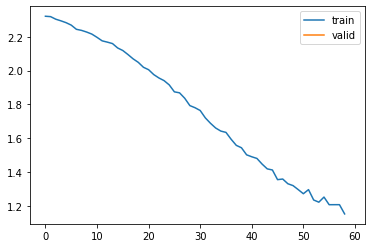

In [ ]:
l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics_s, device_s, progress_s, activation_stats_s])
l.fit(1)

/tmp/ipykernel_428/652453590.py:33: UserWarning: The handle <matplotlib.lines.Line2D object> has a label of '_Sequential' which cannot be automatically added to the legend.
  plt.legend(legend);


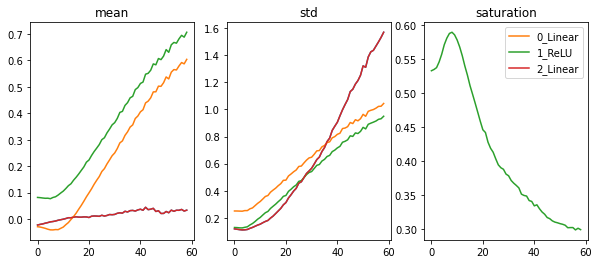

In [ ]:
activation_stats_s.plot()

epoch,mode,loss,accuracy
0,train,2.298,0.136
0,eval,2.275,0.156
1,train,1.576,0.450
1,eval,1.012,0.603
2,train,0.829,0.688
2,eval,0.750,0.713
3,train,0.695,0.734
3,eval,0.670,0.747
4,train,0.626,0.763
4,eval,0.592,0.776


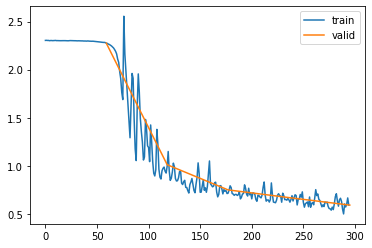

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

model = nn.Sequential(*cnn_layers())

progress_s = ProgressS(True)
metrics_s = MetricsS(accuracy=tem.MulticlassAccuracy())
device_s = DeviceS(device)
activation_stats_s = ActivationStatsS()

collate = partial(hf_ds_collate_fn, flatten=False) 
dls2 = DataLoaders.from_hf_dd(hf_dd, batch_size=bs, collate_fn=collate)

l = Learner(model, dls2, F.cross_entropy, torch.optim.SGD, lr, [metrics_s, device_s, progress_s, activation_stats_s])
l.fit(5, lr=0.2)

/tmp/ipykernel_428/652453590.py:33: UserWarning: The handle <matplotlib.lines.Line2D object> has a label of '_Sequential' which cannot be automatically added to the legend.
  plt.legend(legend);


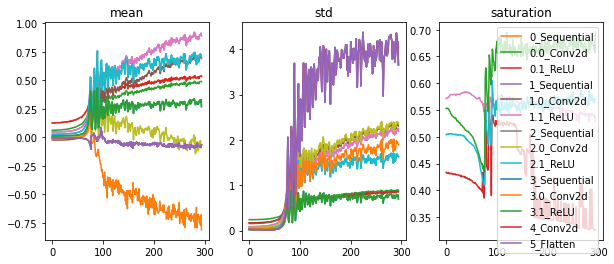

In [ ]:
activation_stats_s.plot()